# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [ ]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.19.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import seaborn as sns                                                                            # Importing seaborn for visualization
import matplotlib.image as mpimg                                                                 # Importing matplotlib.image for visualizing images
import matplotlib.pyplot as plt                                                                  # Importting matplotlib.pyplot for plotting
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing cv2 to perform image processing operations


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from tensorflow.keras.models import Model                                                        # Importing Model to build custom neural networks for deep learning
from keras.applications.vgg16 import VGG16                                                       # Importing VGG16 as a pretrained model

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                     # Importing cv2_imshow from google.patches to display images

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [ ]:
#Loading the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the images
rgb_images = np.load('/content/drive/MyDrive/Datasets/images_proj.npy')

#Loading the labels
labels = pd.read_csv('/content/drive/MyDrive/Datasets/Labels_proj.csv')

In [ ]:
#Checking the number of images, size, and channels of the data
print(rgb_images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


There are a total of 631 images in the dataset with corresponding labels. The images are 200x200 pixels and in RGB color with all 3 channels accounted for.

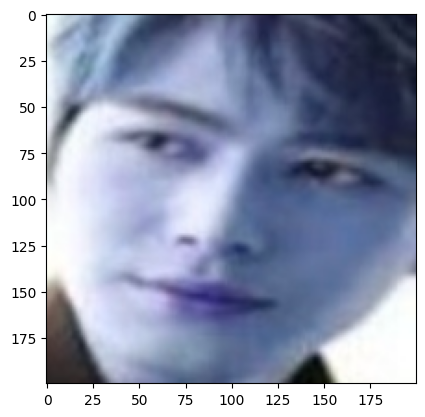

In [ ]:
#Checking a single random image to ensure the data has loaded correctly
random_index = np.random.randint(0, len(labels))
plt.imshow(rgb_images[random_index])
plt.show()

# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

In [ ]:
#Defining a function to display randomly selected images from the dataset with their corresponding labels
def plot_images(images,labels):
    keys=dict(labels['Label'])
    rows = 3
    cols = 4
    fig = plt.figure(figsize=(10, 8))
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(labels))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.imshow(images[random_index, :])
            ax.set_title(keys[random_index])
    plt.show()

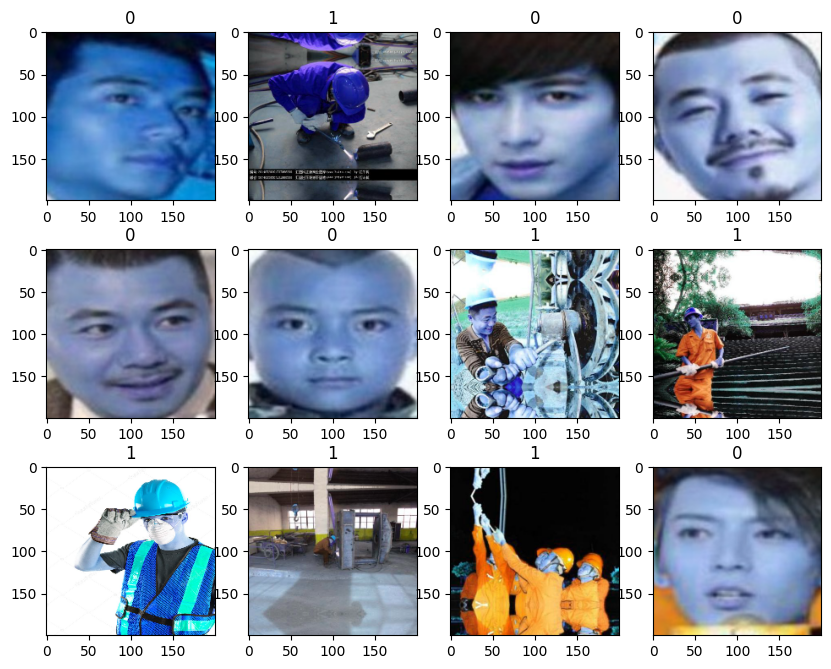

In [ ]:
#Calling the plot images function on the dataset
plot_images(rgb_images,labels)

From the random selection of images displayed here, we can see the dataset contains images of various people at various distances in various hues and positions with helmets on, but all of the images of people without helmets are simply close-ups of the face. This leads me to believe the models will perform exceptionally well.

## Checking for class imbalance


<Axes: xlabel='Label', ylabel='count'>

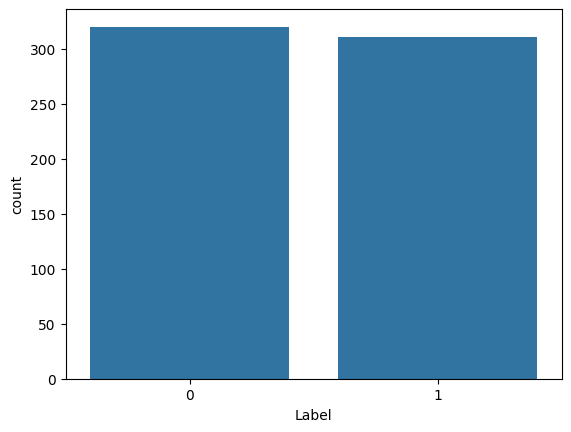

In [ ]:
#Using the seaborne library to plot the # of images of each category to check for class imbalances
sns.countplot(x=labels['Label'])

The dataset is very balanced with ~300 images for each category.

# **Data Preprocessing**

In [ ]:
# Function to plot the original and processed images side by side
def grid_plot(img1,img2,gray=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img1)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    if gray:
      axes[1].imshow(img2,cmap='gray')
    else:
      axes[1].imshow(img2)
    axes[1].set_title('Processed Image')
    axes[1].axis('off')

    plt.show()

## Converting images to grayscale

In [ ]:
#Converting images to grayscale and storing them in the variable "gray_images"
gray_images = []
for i in range(len(rgb_images)):
  gray_images.append(cv2.cvtColor(rgb_images[i], cv2.COLOR_RGB2GRAY))

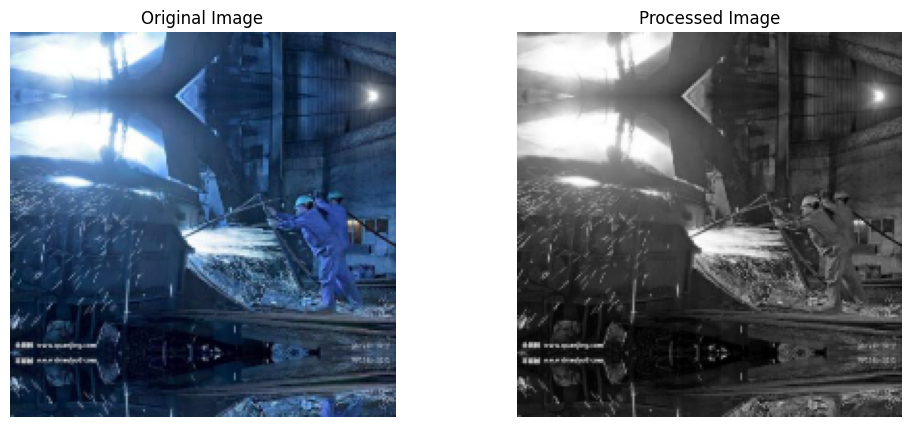

In [ ]:
#Choosing an image to display the original v. the grayscale
n = 5
grid_plot(rgb_images[n],gray_images[n],gray=True)

The RGB component has been successfully removed from the original images and successfully converted to grayscale. **However, since the rubric is unclear as to whether to proceed with training on RGB or grayscale images, we will move forward training all models on RGB images.**

### Splitting the dataset



In [ ]:
#Splitting the rgb_images dataset into training and temporary using train_test_split from sklearn.model_selection with an 80/20 split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(rgb_images), labels, test_size=0.35, random_state=42, stratify=labels)

#Further splitting the temporary gray dataset into validation and test using a 50/50 split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
#Checking the new shape of each dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (410, 200, 200, 3)
Shape of y_train: (410, 1)
Shape of X_val: (110, 200, 200, 3)
Shape of y_val: (110, 1)
Shape of X_test: (111, 200, 200, 3)
Shape of y_test: (111, 1)


Given the very small dataset we are working with, I wanted just enough training data to train the models but still leave a larger validation and test set to give a better idea of how it will perform on unseen data. That led me to use 65% for training, and ~17% for validation and 17% for test.

### Data Normalization

Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

In [ ]:
# Normalizing the image values for each dataset
X_train_norm = X_train.astype('float32')/255.0
X_val_norm = X_val.astype('float32')/255.0
X_test_norm = X_test.astype('float32')/255.0

# **Model Building**

##Model Evaluation Criterion

**Given the balanced nature of the dataset, we'll be using accuracy as our metric of choice in determining the best model.**

## Utility Functions

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [ ]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

**To begin, we'll build and train a simple CNN to make predictions on whether a worker is wearing a helmet or not.**

In [ ]:
#Initializing the model
model_1 = Sequential()
#Adding the convolution, pooling layers, and batch normalization layers
model_1.add(Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same')) #Adding a convolution layer with 64 filters, relu activation for non-linearity, and input shape that corresponds with our dataset, and 'same' padding
model_1.add(MaxPooling2D((4, 4), padding='same')) #Adding a max pooling layer to downsample the features
model_1.add(Conv2D(32, (3, 3), activation='relu', padding='same')) #Adding another convolution layer with 32 filters
model_1.add(MaxPooling2D((2, 2), padding='same')) #Adding another max pooling layer
model_1.add(Conv2D(16, (3, 3), activation='relu', padding='same')) #Adding another convolution layer with 32 filters

#Adding the flattening and dense layers
model_1.add(Flatten()) #Flattening the output of the previous layer to prepare it for the fully connected layers
model_1.add(Dense(4, activation='relu')) #Adding a dense layer with 64 units and relu activation
model_1.add(Dense(1, activation='sigmoid')) #Adding the output layer with sigmoid activation

# Compile with Adam Optimizer, binary crossentropy, and chosen metrics
opt = Adam(learning_rate=0.0001)
model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

#Displaying the model summary
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        40,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,889 (253.47 KB)

 Trainable params: 64,889 (253.47 KB)

 Non-trainable params: 0 (0.00 B)

**Our CNN model consists of 3 convolution layers, 2 pooling layers, one flattening layer, 1 dense layer, and 1 output layer.  We'll have a total of ~64K trainable parameters in this model.**

In [ ]:
#Training the model
history_1 = model_1.fit(
    X_train_norm, y_train, batch_size=64, epochs=10, validation_data=(X_val_norm, y_val), shuffle=True, verbose=2)

Epoch 1/10
7/7 - 6s - 909ms/step - accuracy: 0.4829 - loss: 0.6912 - val_accuracy: 0.5636 - val_loss: 0.6671
Epoch 2/10
7/7 - 1s - 81ms/step - accuracy: 0.8805 - loss: 0.6405 - val_accuracy: 0.9000 - val_loss: 0.6168
Epoch 3/10
7/7 - 0s - 69ms/step - accuracy: 0.9439 - loss: 0.5842 - val_accuracy: 0.9636 - val_loss: 0.5461
Epoch 4/10
7/7 - 0s - 68ms/step - accuracy: 0.9756 - loss: 0.4995 - val_accuracy: 0.9364 - val_loss: 0.4594
Epoch 5/10
7/7 - 0s - 69ms/step - accuracy: 0.9780 - loss: 0.4053 - val_accuracy: 0.9545 - val_loss: 0.3585
Epoch 6/10
7/7 - 0s - 68ms/step - accuracy: 0.9780 - loss: 0.3032 - val_accuracy: 0.9636 - val_loss: 0.2652
Epoch 7/10
7/7 - 0s - 70ms/step - accuracy: 0.9805 - loss: 0.2170 - val_accuracy: 0.9727 - val_loss: 0.1915
Epoch 8/10
7/7 - 0s - 69ms/step - accuracy: 0.9805 - loss: 0.1547 - val_accuracy: 0.9818 - val_loss: 0.1405
Epoch 9/10
7/7 - 0s - 68ms/step - accuracy: 0.9854 - loss: 0.1129 - val_accuracy: 0.9909 - val_loss: 0.1046
Epoch 10/10
7/7 - 0s - 70ms

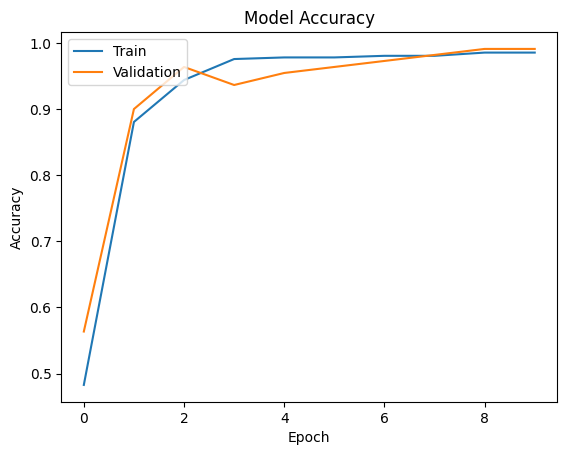

In [ ]:
#Plotting the accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**From the metrics and visualization, it seems our CNN model is performing very well - reaching peak performance around 8 epochs with nearly perfect accuracy. Total training time was ~7 seconds.**

In [ ]:
#Calling the model_performance_classification function to display performance metrics
model_1_train_perf = model_performance_classification(model_1, X_train_norm, y_train)

print("Training Performance:")
print(model_1_train_perf)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
Training Performance:
   Accuracy    Recall  Precision  F1 Score
0  0.985366  0.985366   0.985547  0.985362


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


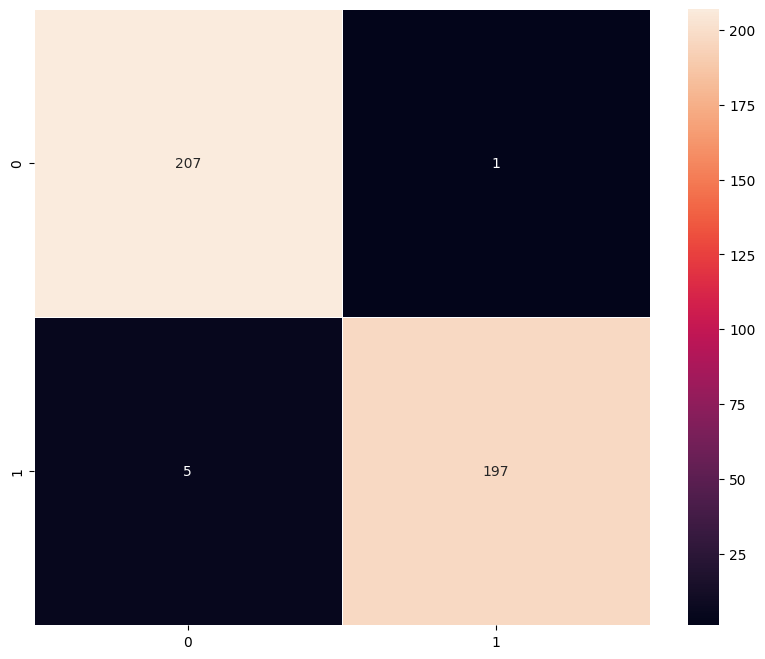

In [ ]:
#Plotting the confusion matrix for my training set
plot_confusion_matrix(model_1,X_train_norm,y_train)

In [ ]:
#Calling the model_performance_classification function to display validation performance
model_1_val_perf = model_performance_classification(model_1, X_val_norm, y_val)

print("Validation Performance:")
print(model_1_val_perf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
Validation Performance:
   Accuracy    Recall  Precision  F1 Score
0  0.990909  0.990909   0.991069  0.990907


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


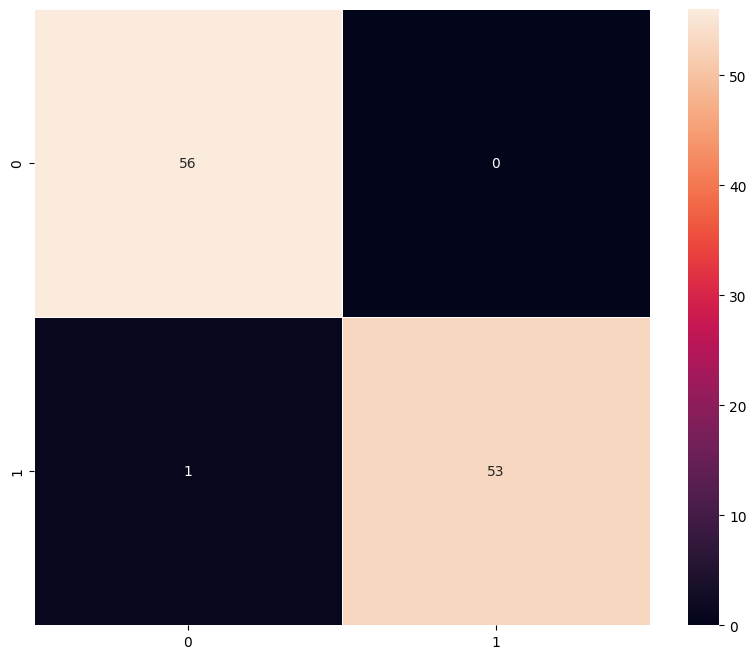

In [ ]:
#Plotting the confusion matrix for my validation set
plot_confusion_matrix(model_1,X_val_norm,y_val)

**The first model performs very well on both training and testing (~98-99% accuracy), but it seems to be struggling with a few instances of workers who ARE wearing helmets, but it is predicting that they are not. That seems acceptable to me, as that is the safest false value we can encounter. It would only spur unnecessary safety checks 1% of the time.**

### Vizualizing the predictions

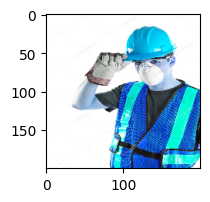

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
Predicted Label: 1
True Label: Label    1
Name: 128, dtype: int64


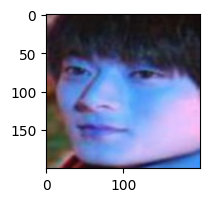

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Label: 0
True Label: Label    0
Name: 307, dtype: int64


In [ ]:
# For index 16
plt.figure(figsize=(2,2))
plt.imshow(X_val[16])
plt.show()
prediction = model_1.predict(X_val_norm[16].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[16]
print('True Label:', true_label)

# For index 33
plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_1.predict(X_val_norm[33].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

**Given the high performance of our model, it's no surprise that our predictions match up with these two images in the dataset. Both the worker with the helmet and the one without are correctly identified.**

## Model 2: (VGG-16 (Base))

Now we'll use the pre-built VGG-16 model with a simple flattening layer and single dense output layer to make predictions on the data for comparison with our previous model. We'll be freezing the convolution layers of the VGG model and applying only their pre-built weights.**

In [ ]:
#Loading a pre-built VGG-16 model for comparison
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Freezing the VGG layers to make them non-trainable.
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
# Initiating a new instance of model
model_2 = Sequential()
# Adding the VGG-16 base model
model_2.add(vgg_model)
# Adding the flattening layer
model_2.add(Flatten())
# Adding the output layer
model_2.add(Dense(1, activation='sigmoid'))

In [ ]:
#Configuring the models parameters
model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Our VGG-16 Base model has about 3x fewer trainable parameters than our simple CNN. ~18K versus ~64K.**

In [ ]:
#Creating the data generator object with default parameters
train_datagen = ImageDataGenerator()

In [ ]:
# Setting epochs to 10
epochs = 10

#Setting batch size to 64
batch_size = 64

#Training the model
history_2 = model_2.fit(
    train_datagen.flow(
        X_train_norm,
        y_train,
        batch_size=batch_size,
        seed=42),
    epochs=epochs,
    shuffle=False,
    validation_data=(X_val_norm, y_val))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.6392 - loss: 0.6548 - val_accuracy: 0.9636 - val_loss: 0.4849
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.9474 - loss: 0.4656 - val_accuracy: 0.9818 - val_loss: 0.3454
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.9910 - loss: 0.3215 - val_accuracy: 1.0000 - val_loss: 0.2491
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 1.0000 - loss: 0.2389 - val_accuracy: 1.0000 - val_loss: 0.1883
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 1.0000 - loss: 0.1861 - val_accuracy: 1.0000 - val_loss: 0.1450
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 1.0000 - loss: 0.1396 - val_accuracy: 1.0000 - val_loss: 0.1172
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - accuracy: 1.0000 - loss: 0.1147 - val_accuracy: 1.0000 - val_loss: 0.0974
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 1.0000 - loss: 0.0962 - val_accuracy: 1.0000 - val_loss: 0

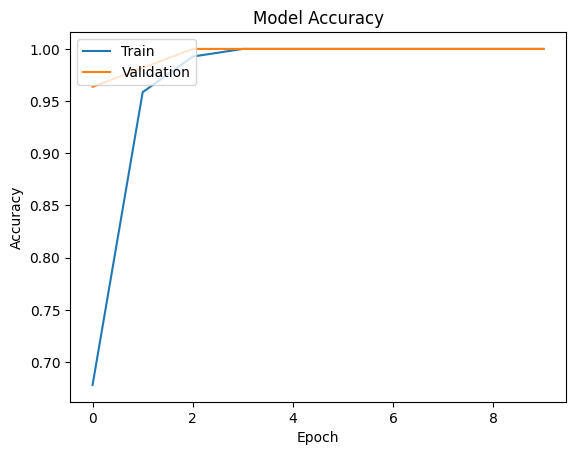

In [ ]:
#Plotting the accuracy for the VGG-16 Base model
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Our VGG-16 Base model achieved peak performance after just 4 epochs.**

In [ ]:
#Calling the model_performance_classification function to display performance metrics
model_2_train_perf = model_performance_classification(model_2, X_train_norm, y_train)

print("Training Performance:")
print(model_2_train_perf)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step
Training Performance:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step


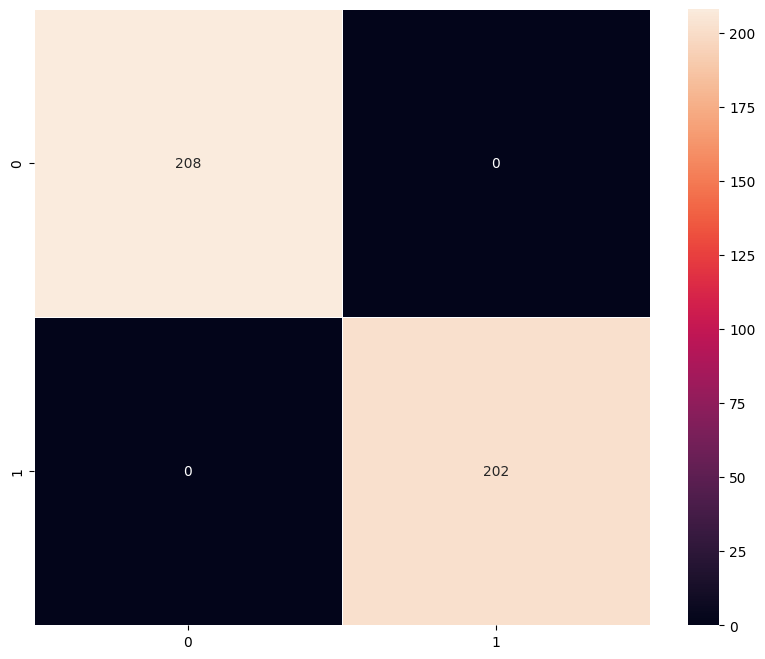

In [ ]:
#Plotting the confusion matrix for my training set
plot_confusion_matrix(model_2, X_train_norm, y_train)

In [ ]:
#Calling the model_performance_classification function to display performance metrics
model_2_val_perf = model_performance_classification(model_2, X_val_norm, y_val)

print("Validation Performance:")
print(model_2_val_perf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
Validation Performance:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


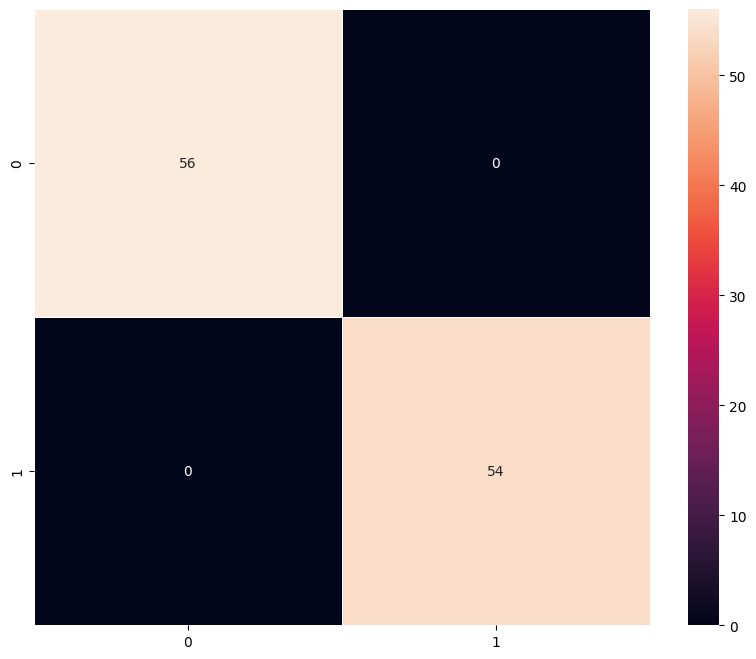

In [ ]:
#Plotting the confusion matrix for my validation set
plot_confusion_matrix(model_2,X_val_norm,y_val)

**This model is achieving 100% accuracy after only 4 epochs, but the trainable parameter count is down from ~64K to only ~18K, reducing computational costs with improved accuracy. Total training time is up to ~77 seconds though.**

### Visualizing the prediction:

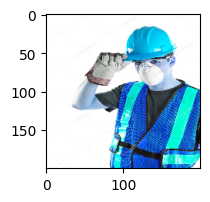

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: 1
True Label: Label    1
Name: 128, dtype: int64


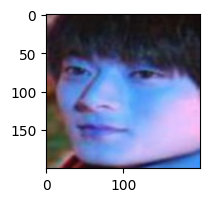

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Label: 0
True Label: Label    0
Name: 307, dtype: int64


In [ ]:
# For index 16
plt.figure(figsize=(2,2))
plt.imshow(X_val[16])
plt.show()
prediction = model_2.predict(X_val_norm[16].reshape(1,200,200,3)) # Correct the reshape shape to (1, 200, 200, 3) for the VGG model
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[16]
print('True Label:', true_label)

# For index 33
plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_2.predict(X_val_norm[33].reshape(1,200,200,3)) # Correct the reshape shape to (1, 200, 200, 3) for the VGG model
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

**We can see that the VGG-16 models predictions match the images and true values in the dataset.**

## Model 3: (VGG-16 (Base + FFNN))

**We'll now use a VGG model with frozen convolution and pooling layers to apply their pre-trained weights to our model, but we'll add a flattening layer along with a simple Feed Forward Neural Network (FFNN).**

In [ ]:
#Initiating a new instance of model
model_3 = Sequential()

#Adding the VGG model previous imported
model_3.add(vgg_model)

#Adding a flattening layer
model_3.add(Flatten())

#Adding the FFNN
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(rate=0.5))
model_3.add(Dense(8, activation='relu'))

#Adding the output layer
model_3.add(Dense(1, activation='sigmoid'))

In [ ]:
# Freezing the VGG layers to make them non-trainable.
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
#Compiling the model
model_3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

#Displaying the model summary
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │       294,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,009,761 (57.26 MB)

 Trainable params: 295,073 (1.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**With just the addition of a small FFNN, we have substantially increased our trainable parameters from previous models up to ~295K.**

In [ ]:
# Setting epochs to 10
epochs = 10

#Setting batch size to 64
batch_size = 64

#Training the model
history_3 = model_3.fit(
    train_datagen.flow(
        X_train_norm,
        y_train,
        batch_size=batch_size,
        seed=42),
    epochs=epochs,
    shuffle=False,
    validation_data=(X_val_norm, y_val))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 868ms/step - accuracy: 0.6228 - loss: 0.7037 - val_accuracy: 0.9727 - val_loss: 0.3992
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.8842 - loss: 0.3945 - val_accuracy: 1.0000 - val_loss: 0.2050
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.9224 - loss: 0.2574 - val_accuracy: 1.0000 - val_loss: 0.1239
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.9470 - loss: 0.1892 - val_accuracy: 1.0000 - val_loss: 0.0859
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - accuracy: 0.9595 - loss: 0.1649 - val_accuracy: 1.0000 - val_loss: 0.0616
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.9376 - loss: 0.1543 - val_accuracy: 1.0000 - val_loss: 0.0494
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9512 - loss: 0.1326 - val_accuracy: 1.0000 - val_loss: 0.0427
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.9381 - loss: 0.1295 - val_accuracy: 1.0000 - val_loss:

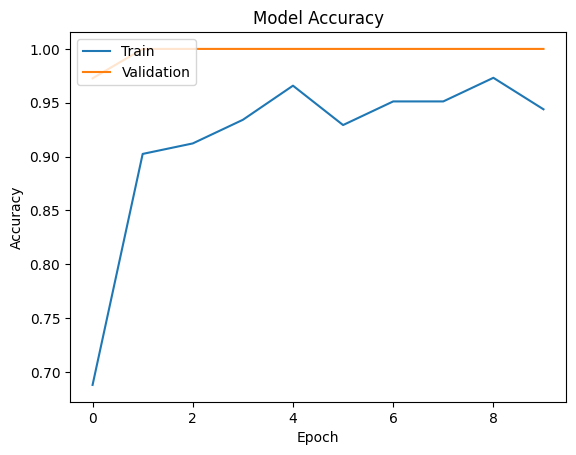

In [ ]:
#Plotting the accuracy for the VGG-16 with FFNN
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#Calling the model_performance_classification function to display performance metrics
model_3_train_perf = model_performance_classification(model_3, X_train_norm, y_train)

print("Training Performance:")
print(model_3_train_perf)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step
Training Performance:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step


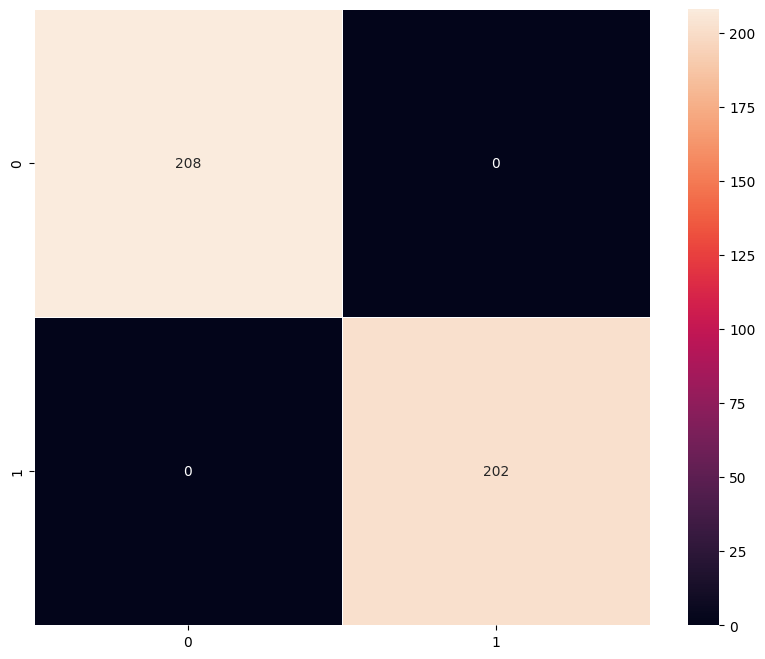

In [ ]:
#Plotting the confusion matrix for my training set
plot_confusion_matrix(model_3, X_train_norm, y_train)

In [ ]:
#Calling the model_performance_classification function to display performance metrics
model_3_val_perf = model_performance_classification(model_3, X_val_norm, y_val)

print("Validation Performance:")
print(model_3_val_perf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Validation Performance:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


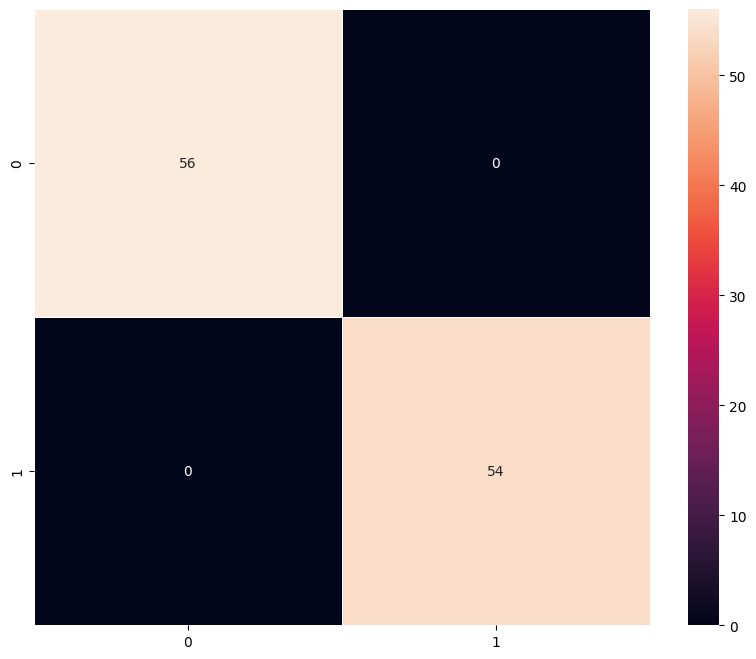

In [ ]:
#Plotting the confusion matrix for my validation set
plot_confusion_matrix(model_3, X_val_norm, y_val)

**Our third model ultimately reached 100% accuracy, but it struggled during training to reach peak performance. The model may be too complex for the training set - starting to memorize noise. Also of note that training is down from the previous model at ~38 seconds total training time.**

#### Visualizing the predictions

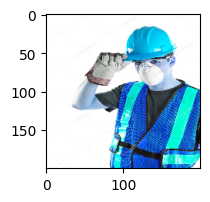

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Predicted Label: 1
True Label: Label    1
Name: 128, dtype: int64


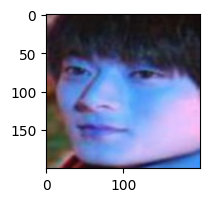

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Label: 0
True Label: Label    0
Name: 307, dtype: int64


In [ ]:
# For index 16
plt.figure(figsize=(2,2))
plt.imshow(X_val[16])
plt.show()
prediction = model_3.predict(X_val_norm[16].reshape(1,200,200,3)) # Correct the reshape shape to (1, 200, 200, 3) for the VGG model
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[16]
print('True Label:', true_label)

# For index 33
plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_3.predict(X_val_norm[33].reshape(1,200,200,3)) # Correct the reshape shape to (1, 200, 200, 3) for the VGG model
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

**Once again, predicted values for the images match the true values in the dataset.**

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
#Initiating a new instance of model
model_4 = Sequential()

#Adding the VGG model previous imported
model_4.add(vgg_model)

#Adding a flattening layer
model_4.add(Flatten())

#Adding the FFNN
model_4.add(Dense(16, activation='relu'))
model_4.add(Dropout(rate=0.5))
model_4.add(Dense(8, activation='relu'))

#Adding the output layer
model_4.add(Dense(1, activation='sigmoid'))

In [ ]:
# Freezing the VGG layers to make them non-trainable.
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
#Compiling the model
model_4.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

#Displaying the model summary
model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │       294,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,009,761 (57.26 MB)

 Trainable params: 295,073 (1.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Since we are using the previous model, our trainable parameters have stayed at ~295k**

In [ ]:
#Setting the augmentation parameters that will be applied to our dataset when fitting the model
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1
)

In [ ]:
# Setting epochs to 10
epochs = 10

#Setting batch size to 64
batch_size = 64

#Training the model
history_4 = model_4.fit(
    train_datagen.flow(
        X_train_norm,
        y_train,
        batch_size=batch_size,
        seed=42),
    epochs=epochs,
    shuffle=False,
    validation_data=(X_val_norm, y_val))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4960 - loss: 0.8151 - val_accuracy: 0.5273 - val_loss: 0.6987
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step - accuracy: 0.5477 - loss: 0.6894 - val_accuracy: 0.7818 - val_loss: 0.6333
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 674ms/step - accuracy: 0.7061 - loss: 0.6079 - val_accuracy: 1.0000 - val_loss: 0.4784
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 696ms/step - accuracy: 0.7807 - loss: 0.5065 - val_accuracy: 1.0000 - val_loss: 0.3230
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 648ms/step - accuracy: 0.8052 - loss: 0.4144 - val_accuracy: 1.0000 - val_loss: 0.2436
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 804ms/step - accuracy: 0.8567 - loss: 0.3613 - val_accuracy: 1.0000 - val_loss: 0.2079
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 648ms/step - accuracy: 0.8743 - loss: 0.3259 - val_accuracy: 1.0000 - val_loss: 0.1877
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step - accuracy: 0.8652 - loss: 0.3172 - val_accuracy: 1.0000 - val_loss: 0

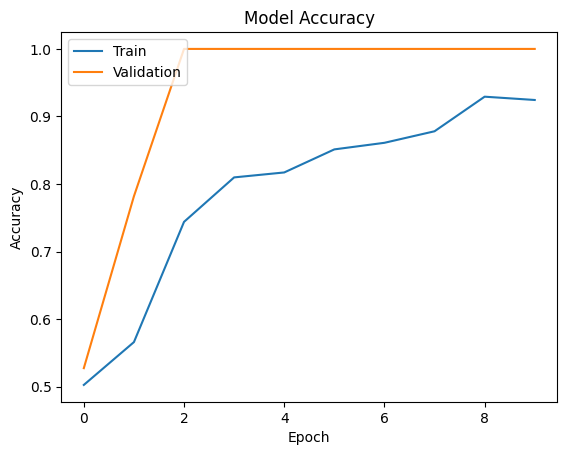

In [ ]:
#Plotting the accuracy for the VGG-16 with FFNN
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#Calling the model_performance_classification function to display performance metrics
model_4_train_perf = model_performance_classification(model_4, X_train_norm, y_train)

print("Training Performance:")
print(model_4_train_perf)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step
Training Performance:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step


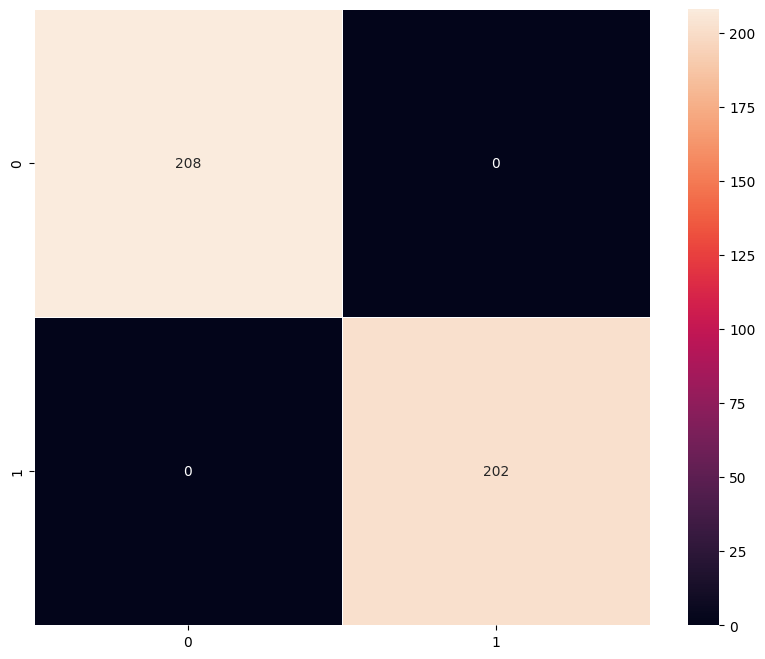

In [ ]:
#Plotting the confusion matrix for my training set
plot_confusion_matrix(model_4,X_train_norm,y_train)

In [ ]:
#Calling the model_performance_classification function to display performance metrics
model_4_val_perf = model_performance_classification(model_4, X_val_norm, y_val)

print("Validation Performance:")
print(model_4_val_perf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Validation Performance:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


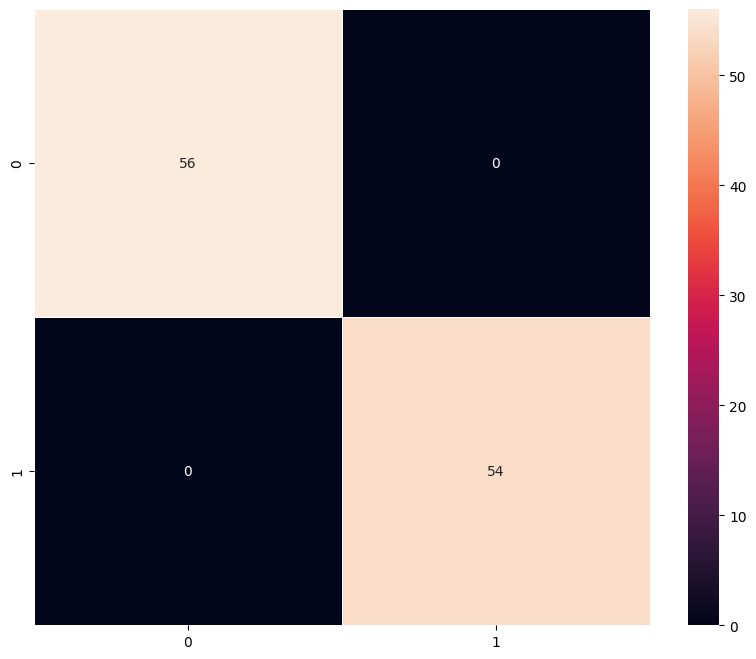

In [ ]:
#Plotting the confusion matrix for my validation set
plot_confusion_matrix(model_4, X_val_norm, y_val)

**While our last model, trained on augmented data struggled to reach maximum performance during training, it eventually got to 100% accuracy. Total training time has increased as well to ~58 seconds.**

#### Visualizing the predictions

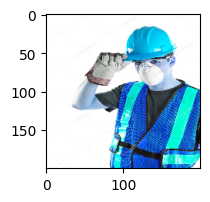

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
Predicted Label: 1
True Label: Label    1
Name: 128, dtype: int64


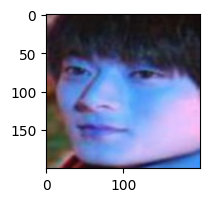

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Label: 0
True Label: Label    0
Name: 307, dtype: int64


In [ ]:
# For index 16
plt.figure(figsize=(2,2))
plt.imshow(X_val[16])
plt.show()
prediction = model_4.predict(X_val_norm[16].reshape(1,200,200,3)) # Correct the reshape shape to (1, 200, 200, 3) for the VGG model
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[16]
print('True Label:', true_label)

# For index 33
plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_4.predict(X_val_norm[33].reshape(1,200,200,3)) # Correct the reshape shape to (1, 200, 200, 3) for the VGG model
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

**No surprise, the predicted values for the images match the true values for the dataset.**

# **Model Performance Comparison and Final Model Selection**

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
models_valid_comp_df = pd.concat(
    [
        model_1_val_perf.T,
        model_2_val_perf.T,
        model_3_val_perf.T,
        model_4_val_perf.T

    ],
    axis=1,
)
models_valid_comp_df.columns = [
 "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
models_train_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.985366,1.0,1.0,1.0
Recall,0.985366,1.0,1.0,1.0
Precision,0.985547,1.0,1.0,1.0
F1 Score,0.985362,1.0,1.0,1.0


In [ ]:
models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.990909,1.0,1.0,1.0
Recall,0.990909,1.0,1.0,1.0
Precision,0.991069,1.0,1.0,1.0
F1 Score,0.990907,1.0,1.0,1.0


In [ ]:
models_train_comp_df - models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,-0.005543,0.0,0.0,0.0
Recall,-0.005543,0.0,0.0,0.0
Precision,-0.005522,0.0,0.0,0.0
F1 Score,-0.005544,0.0,0.0,0.0


**Given that all of the models performed exceptionally well on the data, any one of them could be chosen as the final model. All of them ran quickly with only one exceeding 1 minute in training time. However, I'm inclined to choose the simple VGG-16 base model (model_2) due to it having the fewest trainable parameters and quickest ascent to 100% accuracy.**

## Test Performance

In [ ]:
model_test_perf = model_performance_classification(model_2, X_test_norm, y_test)

print("Test Performance:")
print(model_test_perf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Test Performance:
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


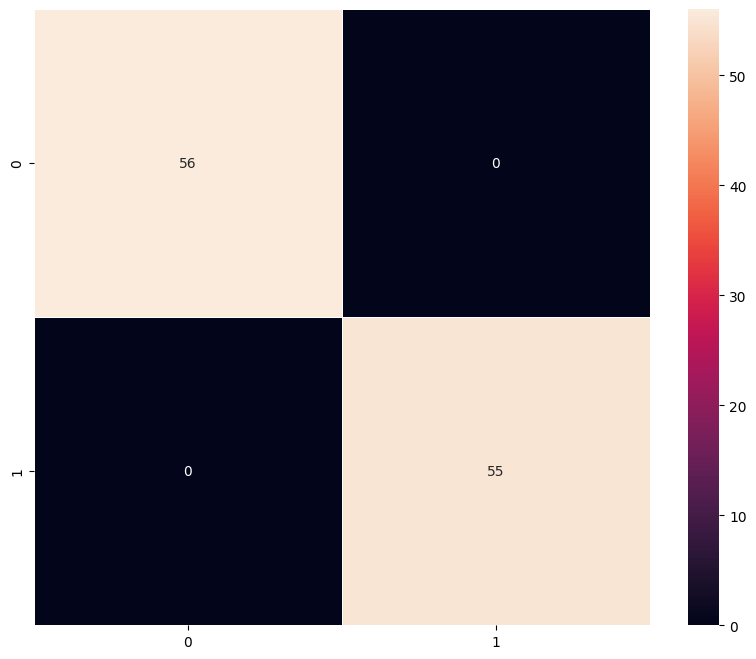

In [ ]:
plot_confusion_matrix(model_2, X_test_norm, y_test)

** Our final model (model_2: VGG-16 Base Model) has proven to be 100% accurate on the test set.**

# **Actionable Insights & Recommendations**

* While the model is performing at 100% accuracy, the dataset provided was too simple and much too small. Images of workers without safety helmets were simply close-ups of peoples faces, and for the most part, all of asian heritage. I would suggest gathering many more diverse images of workers in industrial settings that do not have helmets on that is more comparable to the images of the workers in industrial settings wearing helmets and retrain and test the model before model deployment. It would be an added cost to gather these images, but given the risks, it would be worth it.

* If it is decided that we do not have the budget to gather more images for retraining and testing, I would suggest we tweak model_2 and provide it with augmented images to bolster/confirm it's decision making ability. There could prove to be a substantial difference in performance between the simple VGG-16 Base Model and the added layers of the VGG with FFNN on augmented data.

* Ultimately, with worker safety a main priority, I would suggest that though we have built and are deploying a model that is showing to be 100% accurate, it should not exclude us from instituting or continuing randomized human safety checks as AI is not a replacement for human intuition at this time, and we cannot possibly have cameras covering all of the places workers may hide to take a short break and remove their helmets while still in dangerous positions.

<font size=5 color='blue'>Power Ahead!</font>
___